# 3-2 中阶API示范

下面的范例使用Pytorch的中阶API实现线性回归和DNN二分类模型。

Pytorch的中阶API主要包括各种模型层、损失函数、优化器、数据管道等等。

## 一、线性回归模型

1.准备数据

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import pandas as pd
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
n = 400  # 样本数量

# 生成用于训练的数据集
x = 10*torch.rand([n, 2]) - 5
w0 = torch.tensor([[2.], [-3.]])
b0 = torch.tensor([[10.]])
y = x@w0 + b0 + torch.normal(0.0, 2.0, size=[n, 1])  # 添加正态扰动

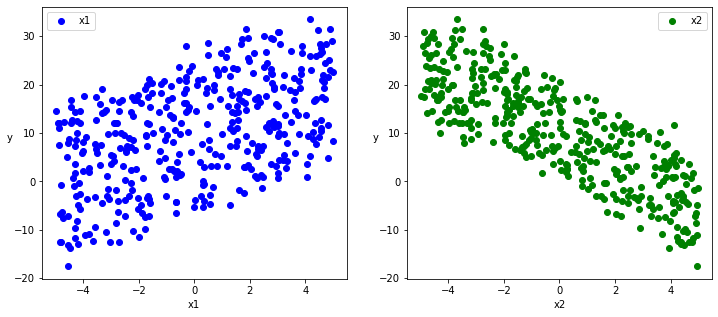

In [3]:
# 可视化数据
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(x[:, 0], y, c="b", label="x1")
plt.xlabel("x1")
plt.ylabel("y", rotation=0)
plt.legend(["x1"])

ax2 = plt.subplot(122)
ax2.scatter(x[:, 1], y, c="g", label="x2")
plt.xlabel("x2")
plt.ylabel("y", rotation=0)
plt.legend(["x2"])

plt.show()

In [4]:
# 构建数据集
ds = TensorDataset(x, y)
dl = DataLoader(ds, batch_size=10, shuffle=True, num_workers=2)

### 2.定义模型

In [5]:
model = nn.Linear(2, 1)  # 定义线性层模型
model.loss_func = nn.MSELoss()
model.optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### 3.训练模型

In [6]:
def train_step(model, features, labels):
    predictions = model(features)
    loss = model.loss_func(predictions, labels)
    loss.backward()
    model.optimizer.step()
    model.optimizer.zero_grad()
    return loss.item()

In [7]:
features, labels = next(iter(dl))  # dl在这里支持iterable, 不是iterator, 所以要使用next就需要iterator
train_step(model, features, labels)

189.57437133789062

In [8]:
def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        for features, labels in dl:
            loss = train_step(model, features, labels)

        if epoch % 50 == 0:
            print("epochs:{}, loss:{:.3f}".format(epoch, loss))

In [9]:
train_model(model, 200)

epochs:50, loss:6.322
epochs:100, loss:3.470
epochs:150, loss:3.569
epochs:200, loss:6.770


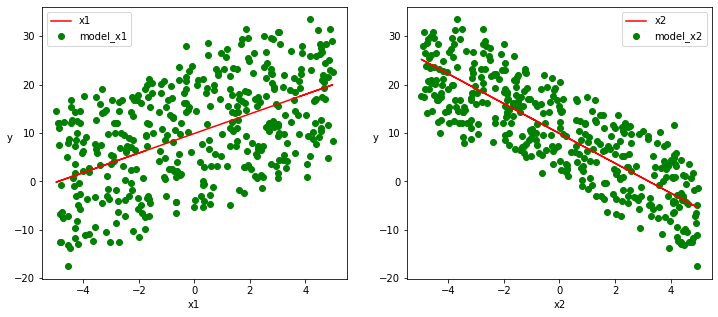

In [10]:
w, b = model.state_dict()["weight"], model.state_dict()["bias"]
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(x[:, 0], y, c="g")
ax1.plot(x[:, 0], torch.squeeze(w[:, [0]]@x[:, [0]].t() + b[0]), "-r")
plt.legend(["x1", "model_x1"])
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(x[:, 1], y, c="g")
ax2.plot(x[:, 1], torch.squeeze(w[:, [1]]@x[:, [1]].t() + b[0]), "-r")
plt.legend(["x2", "model_x2"])
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

plt.show()

## 二、DNN二分类

### 1.准备数据

In [11]:
n_positive, n_negative = 2000, 2000

# 生成正样本, 小圆环
r_p = 5.0 + torch.normal(0.0, 1.0, size=[n_positive, 1])
theta_p = 2*np.pi*torch.rand([n_positive, 1])
x_p = torch.cat([r_p*torch.cos(theta_p), r_p*torch.sin(theta_p)], axis=1)
y_p = torch.ones_like(r_p)

# 生成负样本, 大圆环
r_n = 8.0 + torch.normal(0.0, 1.0, size=[n_positive, 1])
theta_n = 2*np.pi*torch.rand([n_negative, 1])
x_n = torch.cat([r_n*torch.cos(theta_n), r_n*torch.sin(theta_n)], axis=1)
y_n = torch.zeros_like(r_n)

In [12]:
# 汇总样本
x = torch.cat([x_p, x_n], axis=0)
y = torch.cat([y_p, y_n], axis=0)

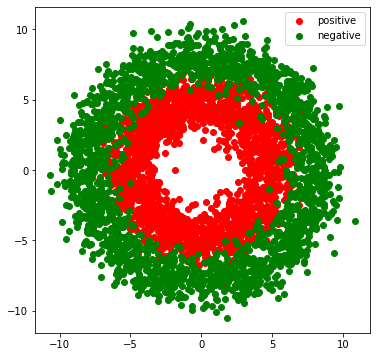

In [13]:
# 可视化样本
plt.figure(figsize=(6, 6))
plt.scatter(x_p[:, 0], x_p[:, 1], c="r")
plt.scatter(x_n[:, 0], x_n[:, 1], c="g")
plt.legend(["positive", "negative"])
plt.show()

In [14]:
# 构建输入管道
ds = TensorDataset(x, y)
dl = DataLoader(ds, batch_size=10, num_workers=2, shuffle=True)

In [15]:
class DNNModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = torch.sigmoid(self.fc3(x))
        return y

    def loss_func(self, y_pred, y_true):
        return nn.BCELoss()(y_pred, y_true)

    def metric_func(self, y_pred, y_true):
        y_pred = torch.where(y_pred>0.5, torch.ones_like(y_pred), torch.zeros_like(y_pred))
        acc = 1 - torch.mean(torch.abs(y_pred-y_true))
        return acc   

    @property
    def optimizer(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [16]:
model = DNNModel()

In [17]:
id(model.optimizer)

140403293092216

In [18]:
id(model.optimizer)  # 这种写法会导致每次返回的optim都不一样

140403293091264

In [19]:
# 测试模型结构
(features,labels) = next(iter(dl))
predictions = model(features)

loss = model.loss_func(predictions, labels)
metric = model.metric_func(predictions, labels)

print("init loss:",loss.item())
print("init metric:",metric.item())

init loss: 0.692777693271637
init metric: 0.5


### 3.训练模型

In [21]:
def train_step(model, features, labels):

    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)

    # 反向传播求梯度
    loss.backward()

    # 更新模型参数
    model.optimizer.step()
    model.optimizer.zero_grad()

    return loss.item(),metric.item()

def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        loss_list,metric_list = [],[]
        for features, labels in dl:
            lossi,metrici = train_step(model,features,labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)

        if epoch%10==0:
            print("epoch =",epoch,"loss = ",loss,"metric = ",metric)

train_model(model,epochs = 10)

epoch = 10 loss =  0.19803952798887622 metric =  0.9264999923110008


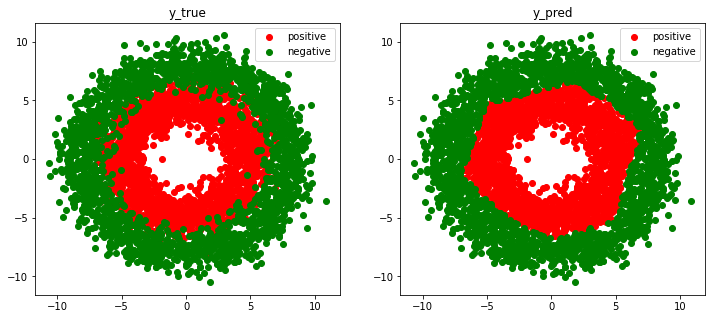

In [23]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(x_p[:,0], x_p[:,1], c="r")
ax1.scatter(x_n[:,0], x_n[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = x[torch.squeeze(model.forward(x)>=0.5)]
Xn_pred = x[torch.squeeze(model.forward(x)<0.5)]

ax2.scatter(Xp_pred[:, 0],Xp_pred[:, 1],c = "r")
ax2.scatter(Xn_pred[:, 0],Xn_pred[:, 1],c = "g")
ax2.legend(["positive", "negative"]);
ax2.set_title("y_pred");